# Model Tuning: Random Forest and XGBoost
Based on the performance of our baseline models (Logistic Regression, SVM, Random Forest, and XGBoost), **Random Forest and XGBoost clearly outperform the others**, particularly in handling the minority class. As such, we focus our tuning efforts on these two tree-based models, as well as a **stacked ensemble method** that combines both Random Forest and XGBoost.

We begin by retraining the XGBoost, Random Forest, and stacked models on training datasets processed using four different resampling strategies: **no resampling, SMOTE, SMOTEENN, and Borderline SMOTE**. Each variation is evaluated using **PRC AUC**, which assesses the model's ability to distinguish between classes under class imbalance.

From these results, we identify the best-performing model and resampling strategy to proceed with **hyperparameter tuning and threshold calibration**. Our tuning will prioritize **recall and F1-score of the minority class (Bad credit)**, due to the high cost of misclassifying high-risk applicants — such misclassifications can result in substantial financial losses for lenders. Therefore, we aim to build a model that maximizes sensitivity to risk without compromising overall classification quality.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, recall_score, accuracy_score,
    precision_recall_curve, auc, average_precision_score, f1_score, make_scorer
)
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline



# Load datasets
train_no_smote = pd.read_csv('../data/processed/train_set.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

## Random Forest Base Model
We evaluate the performance of a baseline Random Forest model with No SMOTE, SMOTE, SMOTEENN, and Borderline SMOTE


--- No SMOTE ---
Accuracy: 0.8409215578716401
Confusion Matrix:
[[ 281  360]
 [ 800 5851]]
Classification Report:
              precision    recall  f1-score   support

         Bad       0.26      0.44      0.33       641
        Good       0.94      0.88      0.91      6651

    accuracy                           0.84      7292
   macro avg       0.60      0.66      0.62      7292
weighted avg       0.88      0.84      0.86      7292


--- SMOTE ---
Accuracy: 0.8712287438288535
Confusion Matrix:
[[ 238  403]
 [ 536 6115]]
Classification Report:
              precision    recall  f1-score   support

         Bad       0.31      0.37      0.34       641
        Good       0.94      0.92      0.93      6651

    accuracy                           0.87      7292
   macro avg       0.62      0.65      0.63      7292
weighted avg       0.88      0.87      0.88      7292


--- SMOTEENN ---
Accuracy: 0.834339001645639
Confusion Matrix:
[[ 239  402]
 [ 806 5845]]
Classification Report:
     

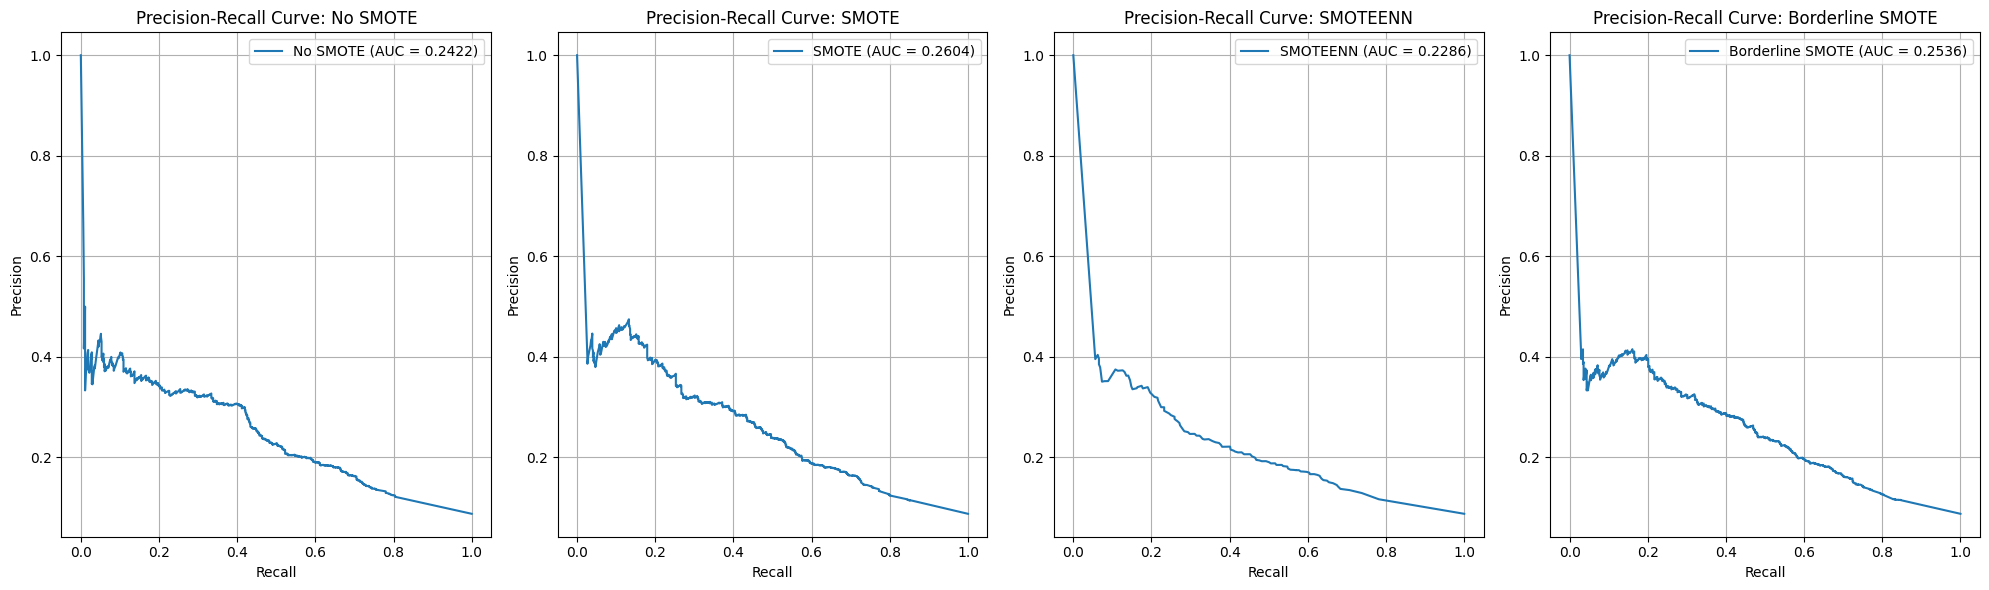

In [4]:
# Function to apply resampling
def apply_resampling(train_df, method):
    X = train_df[feature_columns]
    y = train_df["credit_status"]

    if method == "SMOTE":
        sampler = SMOTE(random_state=42)
    elif method == "SMOTEENN":
        sampler = SMOTEENN(random_state=42)
    elif method == "BorderlineSMOTE":
        sampler = BorderlineSMOTE(random_state=42)
    else:  # No resampling
        return train_df

    X_resampled, y_resampled = sampler.fit_resample(X, y)
    resampled_df = pd.DataFrame(X_resampled, columns=feature_columns)
    resampled_df["credit_status"] = y_resampled
    return resampled_df

# Function to evaluate and collect metrics, PR curve data for different models
def evaluate_and_get_pr_data(train_df, test_df, title="Model"):
    X_train = train_df[feature_columns]
    y_train = train_df["credit_status"]
    X_test = test_df[feature_columns]
    y_test = test_df["credit_status"]

    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    # Classification Report and Metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Encode for PR Curve
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)
    bad_index = list(le.classes_).index('Bad')
    y_scores = rf.predict_proba(X_test)[:, bad_index]

    precision, recall, _ = precision_recall_curve(y_test_encoded, y_scores, pos_label=bad_index)
    pr_auc = auc(recall, precision)

    # Return both PR curve data and performance metrics
    return {
        "title": title,
        "precision": precision,
        "recall": recall,
        "pr_auc": pr_auc,
        "accuracy": accuracy,
        "conf_matrix": conf_matrix,
        "class_report": class_report
    }

# Gather PR curve data and metrics for different resampling methods
results = []
results.append(evaluate_and_get_pr_data(train_no_smote, test_set, title="No SMOTE"))
results.append(evaluate_and_get_pr_data(apply_resampling(train_no_smote, "SMOTE"), test_set, title="SMOTE"))
results.append(evaluate_and_get_pr_data(apply_resampling(train_no_smote, "SMOTEENN"), test_set, title="SMOTEENN"))
results.append(evaluate_and_get_pr_data(apply_resampling(train_no_smote, "BorderlineSMOTE"), test_set, title="Borderline SMOTE"))

# Create subplots to display PR curves side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns
for i, result in enumerate(results):
    # Display metrics (Accuracy, Confusion Matrix, and Classification Report)
    print(f"\n--- {result['title']} ---")
    print(f"Accuracy: {result['accuracy']}")
    print("Confusion Matrix:")
    print(result['conf_matrix'])
    print("Classification Report:")
    print(result['class_report'])

    # Plot PR Curve
    ax = axes[i]  # Get the subplot axis
    ax.plot(result["recall"], result["precision"], label=f'{result["title"]} (AUC = {result["pr_auc"]:.4f})')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve: {result['title']}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

## XGBoost Base Model
We evaluate the performance of a baseline XGBoost model with No SMOTE, SMOTE, SMOTEENN, and Borderline SMOTE


--- XGBoost (No SMOTE) ---
Accuracy: 0.9094898518924849
Confusion Matrix:
[[  23  618]
 [  42 6609]]
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.04      0.07       641
           1       0.91      0.99      0.95      6651

    accuracy                           0.91      7292
   macro avg       0.63      0.51      0.51      7292
weighted avg       0.87      0.91      0.87      7292


--- XGBoost (SMOTE) ---
Accuracy: 0.8690345584201865
Confusion Matrix:
[[ 143  498]
 [ 457 6194]]
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.22      0.23       641
           1       0.93      0.93      0.93      6651

    accuracy                           0.87      7292
   macro avg       0.58      0.58      0.58      7292
weighted avg       0.87      0.87      0.87      7292


--- XGBoost (SMOTEENN) ---
Accuracy: 0.8853538123971476
Confusion Matrix:
[[  72  569]
 [ 267 6384

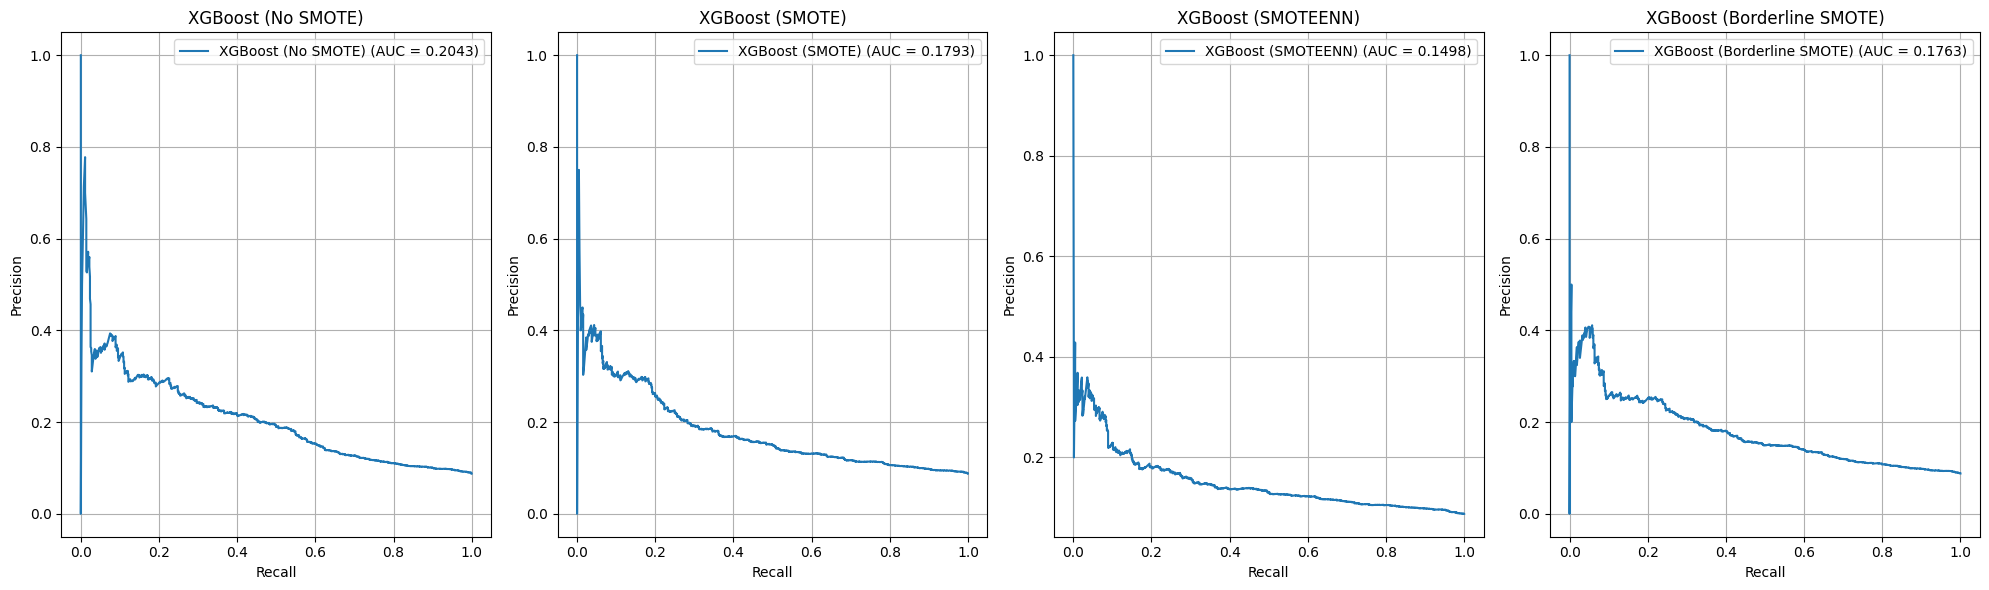

In [5]:
# Function to apply resampling
def apply_resampling(train_df, method):
    X = train_df[feature_columns]
    y = train_df["credit_status"]

    if method == "SMOTE":
        sampler = SMOTE(random_state=42)
    elif method == "SMOTEENN":
        sampler = SMOTEENN(random_state=42)
    elif method == "BorderlineSMOTE":
        sampler = BorderlineSMOTE(random_state=42)
    else:  # No resampling
        return train_df

    X_res, y_res = sampler.fit_resample(X, y)
    resampled_df = pd.DataFrame(X_res, columns=feature_columns)
    resampled_df["credit_status"] = y_res
    return resampled_df

# Function to evaluate and collect metrics + PR curve data using XGBoost
def evaluate_xgb_model(train_df, test_df, title="XGBoost Model"):
    le = LabelEncoder()
    y_train = le.fit_transform(train_df["credit_status"])
    y_test = le.transform(test_df["credit_status"])
    bad_index = list(le.classes_).index("Bad")

    X_train = train_df[feature_columns]
    X_test = test_df[feature_columns]

    xgb = XGBClassifier(eval_metric='logloss')
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    # Collect metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # PR curve data
    y_probs = xgb.predict_proba(X_test)[:, bad_index]
    y_test_binary = (y_test == bad_index).astype(int)
    precision, recall, _ = precision_recall_curve(y_test_binary, y_probs)
    prc_auc = auc(recall, precision)

    return {
        "title": title,
        "precision": precision,
        "recall": recall,
        "pr_auc": prc_auc,
        "accuracy": accuracy,
        "conf_matrix": conf_matrix,
        "class_report": class_report
    }

# Gather results for all 4 versions
xgb_results = []
xgb_results.append(evaluate_xgb_model(train_no_smote, test_set, title="XGBoost (No SMOTE)"))
xgb_results.append(evaluate_xgb_model(apply_resampling(train_no_smote, "SMOTE"), test_set, title="XGBoost (SMOTE)"))
xgb_results.append(evaluate_xgb_model(apply_resampling(train_no_smote, "SMOTEENN"), test_set, title="XGBoost (SMOTEENN)"))
xgb_results.append(evaluate_xgb_model(apply_resampling(train_no_smote, "BorderlineSMOTE"), test_set, title="XGBoost (Borderline SMOTE)"))

# Plot PR curves side by side
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns
for i, result in enumerate(xgb_results):
    # Print metrics
    print(f"\n--- {result['title']} ---")
    print(f"Accuracy: {result['accuracy']}")
    print("Confusion Matrix:")
    print(result['conf_matrix'])
    print("Classification Report:")
    print(result['class_report'])

    # Plot PR Curve
    ax = axes[i]
    ax.plot(result["recall"], result["precision"], label=f'{result["title"]} (AUC = {result["pr_auc"]:.4f})')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(result['title'])
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## Stacking Base Model: Combining Random Forest and XGBoost
We evaluate the performance of a baseline stacked RF and XGB model with No SMOTE, SMOTE, SMOTEENN, and Borderline SMOTE


--- Stacking (No SMOTE) ---
Accuracy: 0.912095447065277
Confusion Matrix:
 [[   5  636]
 [   5 6646]]
Classification Report:
               precision    recall  f1-score   support

         Bad       0.50      0.01      0.02       641
        Good       0.91      1.00      0.95      6651

    accuracy                           0.91      7292
   macro avg       0.71      0.50      0.48      7292
weighted avg       0.88      0.91      0.87      7292


--- Stacking (SMOTE) ---
Accuracy: 0.8775370268787712
Confusion Matrix:
 [[ 200  441]
 [ 452 6199]]
Classification Report:
               precision    recall  f1-score   support

         Bad       0.31      0.31      0.31       641
        Good       0.93      0.93      0.93      6651

    accuracy                           0.88      7292
   macro avg       0.62      0.62      0.62      7292
weighted avg       0.88      0.88      0.88      7292


--- Stacking (SMOTEENN) ---
Accuracy: 0.8391387822270981
Confusion Matrix:
 [[ 226  415]
 [ 7

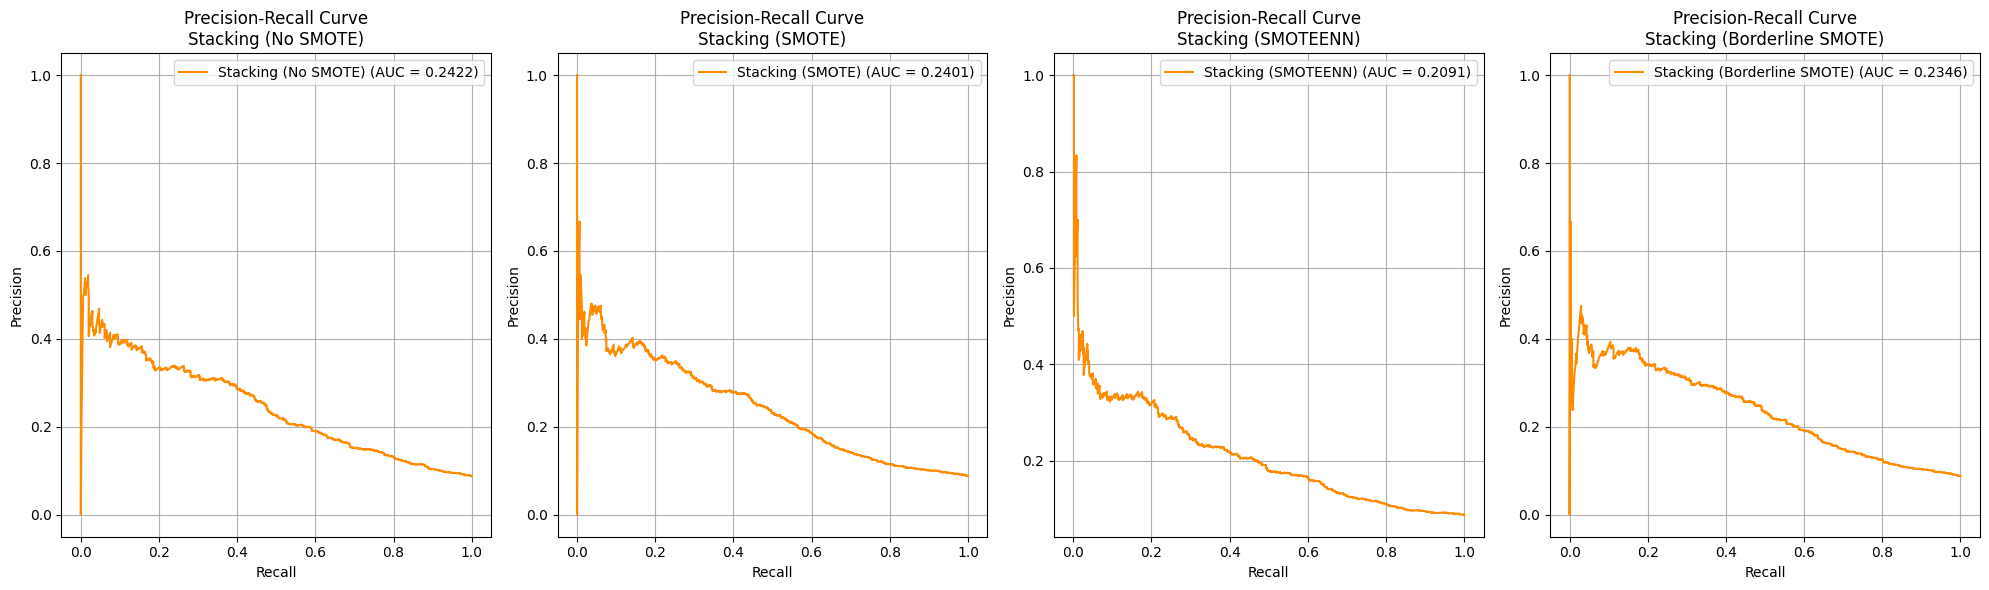

In [6]:
# Define reusable resampling function
def apply_resampling(train_df, method):
    X = train_df[feature_columns]
    y = train_df["credit_status"]

    if method == "SMOTE":
        sampler = SMOTE(random_state=42)
    elif method == "SMOTEENN":
        sampler = SMOTEENN(random_state=42)
    elif method == "BorderlineSMOTE":
        sampler = BorderlineSMOTE(random_state=42)
    else:
        return train_df  # No resampling

    X_res, y_res = sampler.fit_resample(X, y)
    resampled_df = pd.DataFrame(X_res, columns=feature_columns)
    resampled_df["credit_status"] = y_res
    return resampled_df

# Unified evaluation function
def evaluate_stacking_model(train_df, test_df, title="Stacking Model"):
    # Encode target
    le = LabelEncoder()
    y_train = le.fit_transform(train_df["credit_status"])
    y_test = le.transform(test_df["credit_status"])
    bad_index = list(le.classes_).index("Bad")

    # Feature matrices
    X_train = train_df[feature_columns]
    X_test = test_df[feature_columns]

    # Define stacking classifier
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    xgb = XGBClassifier(eval_metric='logloss')

    stacking_model = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb)],
        final_estimator=LogisticRegression(max_iter=2000),
        passthrough=True,
        n_jobs=-1
    )

    # Train and predict
    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_test)
    y_probs = stacking_model.predict_proba(X_test)[:, bad_index]

    # Binary indicator for "Bad" class
    y_test_binary = (y_test == bad_index).astype(int)

    # PRC computation
    precision, recall, _ = precision_recall_curve(y_test_binary, y_probs)
    prc_auc = auc(recall, precision)

    # Print metrics
    print(f"\n--- {title} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    # Return for plotting
    return {
        "title": title,
        "precision": precision,
        "recall": recall,
        "pr_auc": prc_auc,
        "accuracy": accuracy_score(y_test, y_pred),
        "conf_matrix": confusion_matrix(y_test, y_pred),
        "class_report": classification_report(y_test, y_pred, target_names=le.classes_)
    }

# Run evaluations
results = []
results.append(evaluate_stacking_model(train_no_smote, test_set, title="Stacking (No SMOTE)"))
results.append(evaluate_stacking_model(apply_resampling(train_no_smote, "SMOTE"), test_set, title="Stacking (SMOTE)"))
results.append(evaluate_stacking_model(apply_resampling(train_no_smote, "SMOTEENN"), test_set, title="Stacking (SMOTEENN)"))
results.append(evaluate_stacking_model(apply_resampling(train_no_smote, "BorderlineSMOTE"), test_set, title="Stacking (Borderline SMOTE)"))

# Plot PR Curves
fig, axes = plt.subplots(1, 4, figsize=(20, 6))  # 1 row, 4 columns
for i, result in enumerate(results):
    print(f"\n--- {result['title']} ---")
    print(f"Accuracy: {result['accuracy']}")
    print("Confusion Matrix:")
    print(result['conf_matrix'])
    print("Classification Report:")
    print(result['class_report'])

    ax = axes[i]
    ax.plot(result["recall"], result["precision"], label=f'{result["title"]} (AUC = {result["pr_auc"]:.4f})', color='darkorange')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve\n{result['title']}")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



## Tuning Random Forest Model

Based on the results, the **Random Forest model using Borderline SMOTE** achieved one of the highest PRC AUC scores while also maintaining a strong balance between recall and precision for the minority class. Given its superior performance in identifying high-risk applicants, further tuning efforts will focus on this model to optimize its ability to detect risky credit profiles.

### Hyperparameter Tuning to Maximise Recall

In [ ]:
### Random Forest + Borderline SMOTE
### Hyperparameters Tuning RF with Borderline SMOTE to maximise recall
### WARNING: WILL RUN FOR ~ 35 MINUTES

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_no_smote['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

X_train = train_no_smote[feature_columns]
X_test = test_set[feature_columns]

# Build pipeline
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [True, False],
    'clf__max_samples': [None, 0.8, 0.6],
    'clf__class_weight': [None, 'balanced']
}

# Use Recall score where 'Bad' is positive class (1)
recall_scorer = make_scorer(recall_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=recall_scorer,
    n_jobs=-1,
    verbose=0
)

# Fit model
grid_search.fit(X_train, y_train)
pipeline = grid_search.best_estimator_

# Predict with best model using default threshold = 0.5
y_pred = pipeline.predict(X_test)

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("Classification Report (Bad = 1):")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PRC AUC
y_proba = pipeline.predict_proba(X_test)[:, 1]  # prob of class 1 = Bad
precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label=1)    # Not concerned with thresholds for now, hence throwaway
prc_auc = auc(recall, precision)
print(f"PRC AUC: {prc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Bad = 1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']
print("\n", feat_imp_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
576 fits failed out of a total of 1728.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
576 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi

Best Parameters: {'clf__bootstrap': False, 'clf__class_weight': None, 'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__max_samples': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Classification Report (Bad = 1):
              precision    recall  f1-score   support

        Good       0.94      0.85      0.89      6651
         Bad       0.23      0.45      0.30       641

    accuracy                           0.82      7292
   macro avg       0.58      0.65      0.60      7292
weighted avg       0.88      0.82      0.84      7292

Confusion Matrix:
[[5655  996]
 [ 351  290]]
PRC AUC: 0.2217


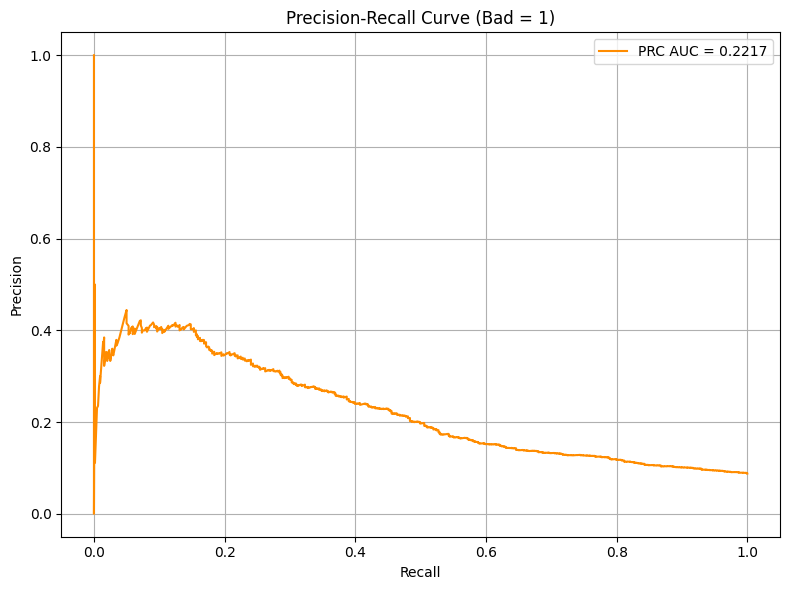


                                          Feature  Importance
0                              log_annual_income    0.201273
1                                            age    0.179811
2                             log_years_employed    0.118346
3                                    family_size    0.066530
4                                        own_car    0.026432
5                                     own_realty    0.024502
6                                          phone    0.024042
7                                         gender    0.022129
8                          family_status_Married    0.021304
9                            income_type_Working    0.021204
10                                    work_phone    0.019637
11  education_type_Secondary / secondary special    0.018472
12                housing_type_House / apartment    0.018040
13                             occupation_Others    0.017827
14               education_type_Higher education    0.017507
15                    

/var/folders/bm/l7y0dmw152vcmvqzjv7gpb6c0000gn/T/ipykernel_8223/2868286133.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


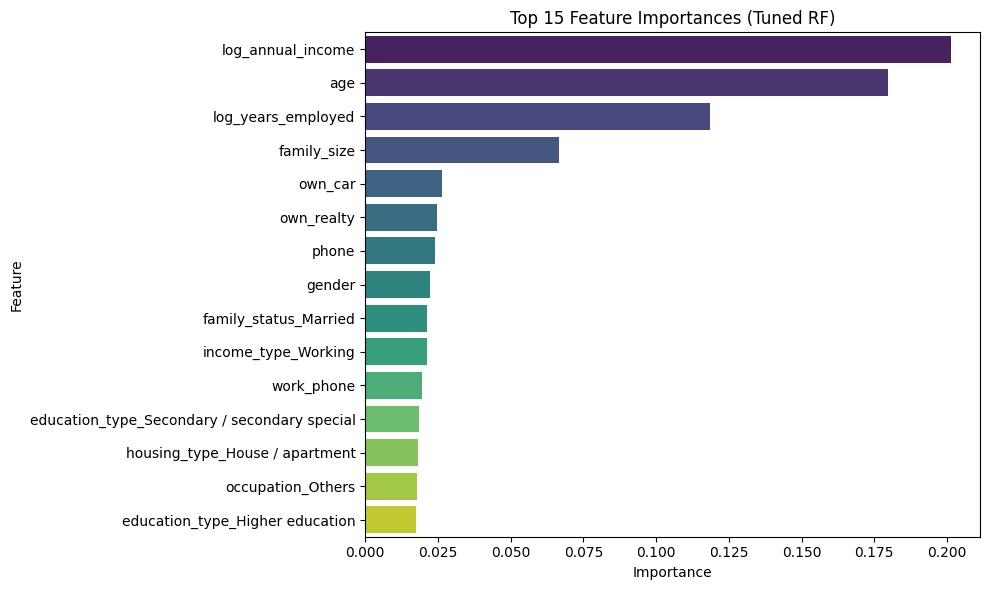

In [ ]:
from sklearn.metrics import recall_score, make_scorer, classification_report, confusion_matrix, precision_recall_curve, auc
### Random Forest + Normal SMOTE
### Hyperparameters Tuning RF with Normal SMOTE to maximise recall
### WARNING: WILL RUN FOR ~ 20 MINUTES


# Load datasets
train_set = pd.read_csv('../data/processed/train_set_SMOTEd.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Build pipeline
pipeline = ImbPipeline([
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [True, False],
    'clf__max_samples': [None, 0.8, 0.6],
    'clf__class_weight': [None, 'balanced']
}

# Use Recall score where 'Bad' is positive class (1)
recall_scorer = make_scorer(recall_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=recall_scorer,
    n_jobs=-1,
    verbose=0
)

# Fit model
grid_search.fit(X_train, y_train)
pipeline = grid_search.best_estimator_

# Predict with best model using default threshold = 0.5
y_pred = pipeline.predict(X_test)

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("Classification Report (Bad = 1):")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PRC AUC
y_proba = pipeline.predict_proba(X_test)[:, 1]  # prob of class 1 = Bad
precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label=1)    # Not concerned with thresholds for now, hence throwaway
prc_auc = auc(recall, precision)
print(f"PRC AUC: {prc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Bad = 1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']
print("\n", feat_imp_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Hyperparameter Tuning to Maximise F1

undone

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


Python(73809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73810) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73811) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73812) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73813) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73815) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(73816) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pas

[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100; total time=   9.5s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100; total time=   9.5s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   9.6s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   9.6s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_l

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
576 fits failed out of a total of 1728.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
576 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi


✅ Best Parameters: {'clf__bootstrap': True, 'clf__class_weight': None, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__max_samples': 0.8, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

🔍 Classification Report (Bad = 1):
              precision    recall  f1-score   support

        Good       0.94      0.92      0.93      6651
         Bad       0.30      0.36      0.32       641

    accuracy                           0.87      7292
   macro avg       0.62      0.64      0.63      7292
weighted avg       0.88      0.87      0.87      7292


🔍 Confusion Matrix:
[[6108  543]
 [ 413  228]]

📈 PRC AUC: 0.2502


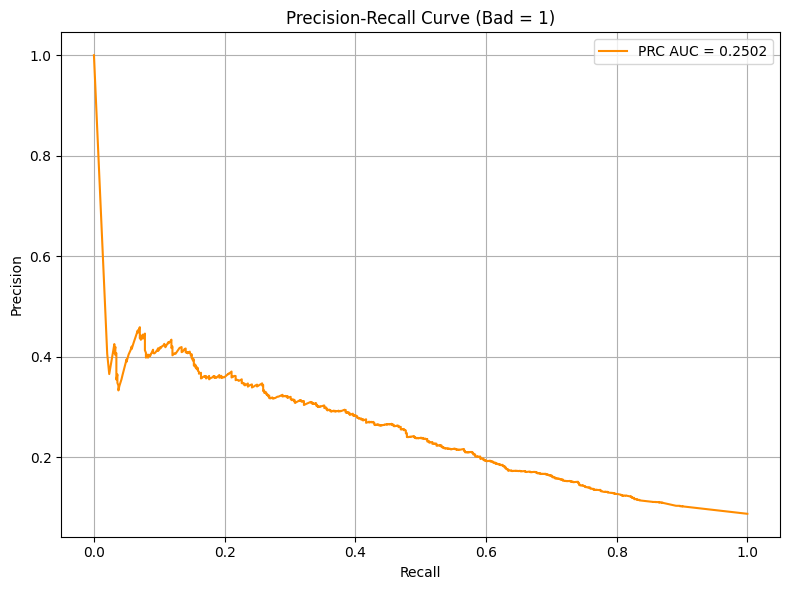


                                          Feature  Importance
0                              log_annual_income    0.218962
1                                            age    0.206955
2                             log_years_employed    0.135818
3                                    family_size    0.055518
4                                        own_car    0.027478
5                                          phone    0.025852
6                                         gender    0.022846
7                                     own_realty    0.020798
8                            income_type_Working    0.019902
9                                     work_phone    0.018942
10                             occupation_Others    0.016578
11  education_type_Secondary / secondary special    0.016289
12                         family_status_Married    0.015487
13               education_type_Higher education    0.015108
14                           occupation_Laborers    0.014388
15                    

/var/folders/bm/l7y0dmw152vcmvqzjv7gpb6c0000gn/T/ipykernel_68141/1390718576.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


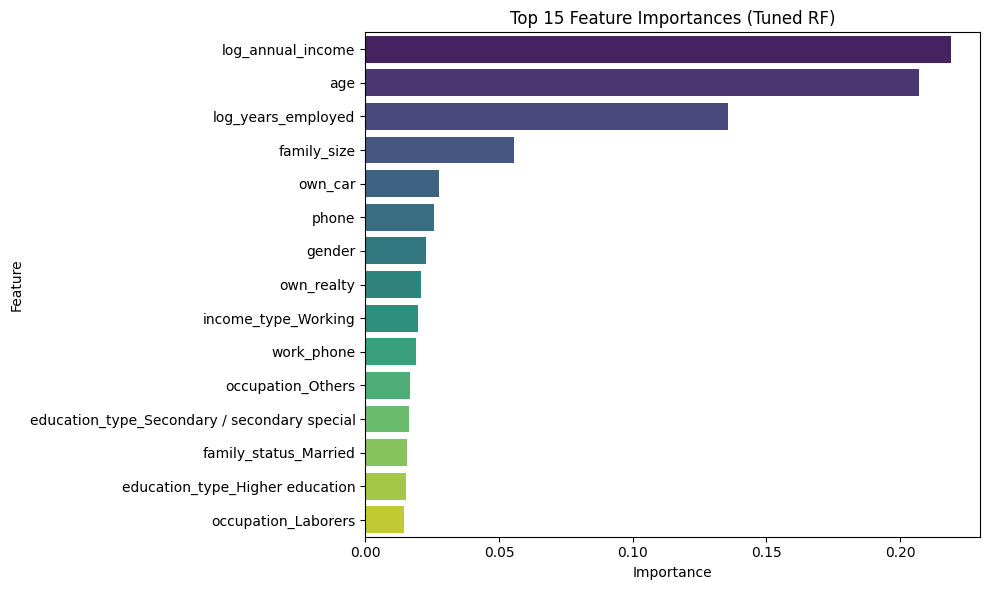

In [ ]:
### Random Forest Model + Borderline SMOTE (Balancing PRC AUC, Recall)
### Hyperparameters Tuning RF with Borderline SMOTE to maximise f1 score
### WARNING: WILL RUN FOR ~ 35 MINUTES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Build pipeline
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [True, False],
    'clf__max_samples': [None, 0.8, 0.6],
    'clf__class_weight': [None, 'balanced']
}

# Use F1 score where 'Bad' is positive class (1)
f1_scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=0
)

# Fit model
grid_search.fit(X_train_reduced, y_train)
print("\n✅ Best Parameters:", grid_search.best_params_)

# Use best estimator
pipeline = grid_search.best_estimator_

# Predict with default threshold = 0.5
y_pred = pipeline.predict(X_test_reduced)

# Evaluation
print("\n🔍 Classification Report (Bad = 1):")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PRC AUC
y_proba = pipeline.predict_proba(X_test_reduced)[:, 1]  # prob of class 1 = Bad
precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label=1)    # Not concerned with thresholds for now, hence throwaway
prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Bad = 1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train_reduced.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']
print("\n", feat_imp_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   7.6s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100; total time=   7.7s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   7.8s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, clf__max_features=sqrt, clf__max_samples=None, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=100; total time=   7.9s
[CV] END clf__bootstrap=True, clf__class_weight=None, clf__max_depth=None, c

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
576 fits failed out of a total of 1728.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
576 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi


✅ Best Parameters: {'clf__bootstrap': False, 'clf__class_weight': None, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__max_samples': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

🔍 Classification Report (Bad = 1):
              precision    recall  f1-score   support

        Good       0.94      0.93      0.93      6651
         Bad       0.31      0.33      0.32       641

    accuracy                           0.88      7292
   macro avg       0.62      0.63      0.63      7292
weighted avg       0.88      0.88      0.88      7292


🔍 Confusion Matrix:
[[6173  478]
 [ 428  213]]

📈 PRC AUC: 0.2765


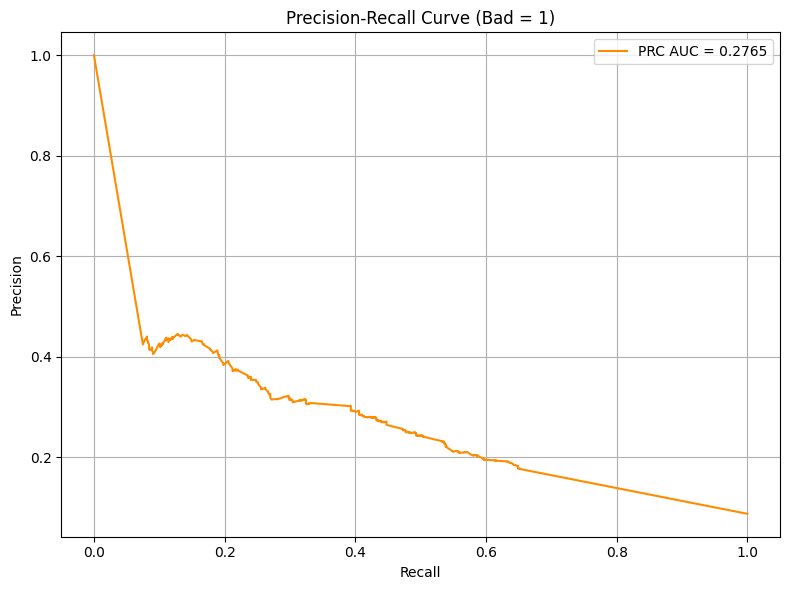


                                          Feature  Importance
0                              log_annual_income    0.223324
1                                            age    0.211565
2                             log_years_employed    0.135935
3                                    family_size    0.057585
4                                        own_car    0.026984
5                                          phone    0.022260
6                                         gender    0.021591
7                            income_type_Working    0.019957
8                                     own_realty    0.019855
9                                     work_phone    0.017631
10                             occupation_Others    0.016502
11  education_type_Secondary / secondary special    0.015274
12                         family_status_Married    0.015251
13                           occupation_Laborers    0.014916
14               education_type_Higher education    0.014536
15                    

/var/folders/bm/l7y0dmw152vcmvqzjv7gpb6c0000gn/T/ipykernel_8223/3677635986.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


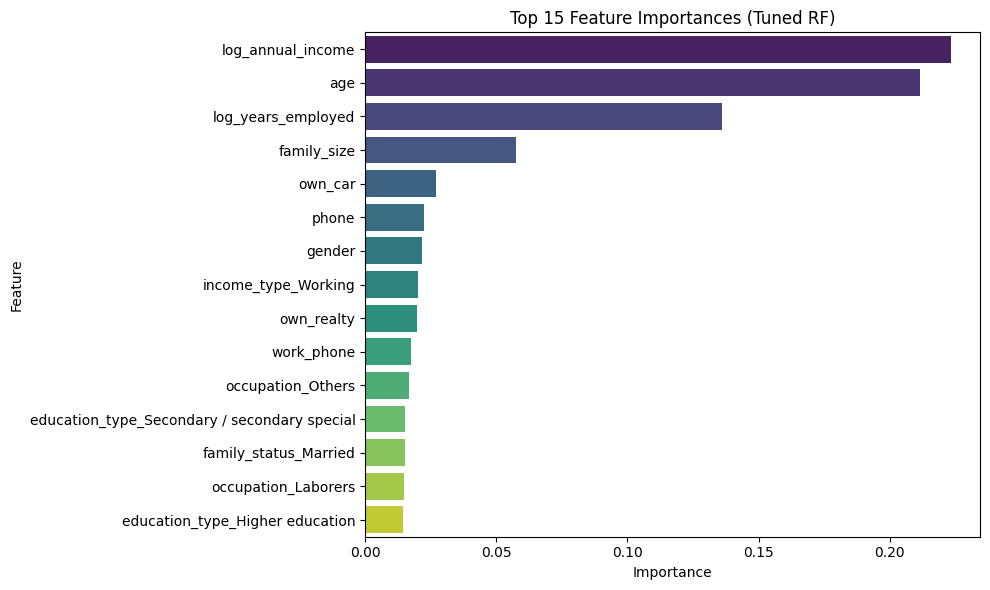

In [ ]:
### Random Forest + NORMAL SMOTE (Balancing PRC AUC, Recall)
### Hyperparameters Tuning RF with NORMAL SMOTE to maximise f1 score
### WARNING: WILL RUN FOR ~ 20 MINUTES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_SMOTEd.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]


# Build pipeline
pipeline = ImbPipeline([
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Define hyperparameter grid
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__bootstrap': [True, False],
    'clf__max_samples': [None, 0.8, 0.6],
    'clf__class_weight': [None, 'balanced']
}

# Use F1 score where 'Bad' is positive class (1)
f1_scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=0
)

# Fit model
grid_search.fit(X_train, y_train)
print("\n✅ Best Parameters:", grid_search.best_params_)

# Use best estimator
pipeline = grid_search.best_estimator_

# Predict with default threshold = 0.5
y_pred = pipeline.predict(X_test)

# Evaluation
print("\n🔍 Classification Report (Bad = 1):")
print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# PRC AUC
y_proba = pipeline.predict_proba(X_test)[:, 1]  # prob of class 1 = Bad
precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label=1)    # Not concerned with thresholds for now, hence throwaway
prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Bad = 1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']
print("\n", feat_imp_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Threshold Tuning while Ensuring Recall for "Bad" class >= 0.50

undone


✅ Selected Threshold (Recall ≥ 0.5): 0.506
Precision: 0.135, Recall: 0.504, F1: 0.212

🔍 Classification Report (Threshold Tuned):
              precision    recall  f1-score   support

        Good       0.93      0.69      0.79      6651
         Bad       0.13      0.50      0.21       641

    accuracy                           0.67      7292
   macro avg       0.53      0.60      0.50      7292
weighted avg       0.86      0.67      0.74      7292


🔍 Confusion Matrix:
[[4573 2078]
 [ 318  323]]

✅ Best Threshold: 0.506

📈 PRC AUC: 0.1416


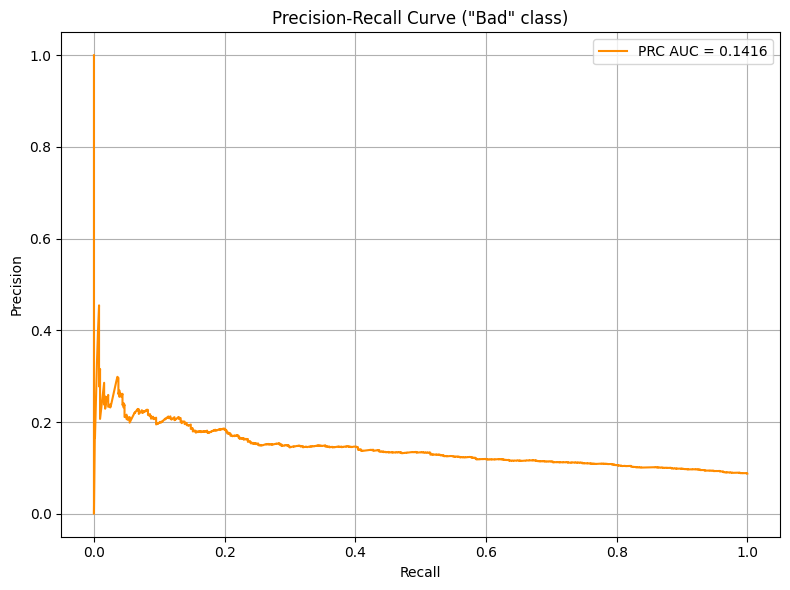


🔍 Top Features:
                                         Feature  Importance
0                              log_annual_income    0.223932
1                                            age    0.166932
2                             log_years_employed    0.089856
3                                    family_size    0.058747
4                          family_status_Married    0.043278
5                                     own_realty    0.031834
6                 housing_type_House / apartment    0.030049
7                                        own_car    0.020105
8                            income_type_Working    0.019057
9                                         gender    0.018519
10  education_type_Secondary / secondary special    0.018253
11                                         email    0.018035
12                                         phone    0.017985
13                     housing_type_With parents    0.016634
14                                    work_phone    0.015767


/var/folders/bm/l7y0dmw152vcmvqzjv7gpb6c0000gn/T/ipykernel_8223/497384654.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


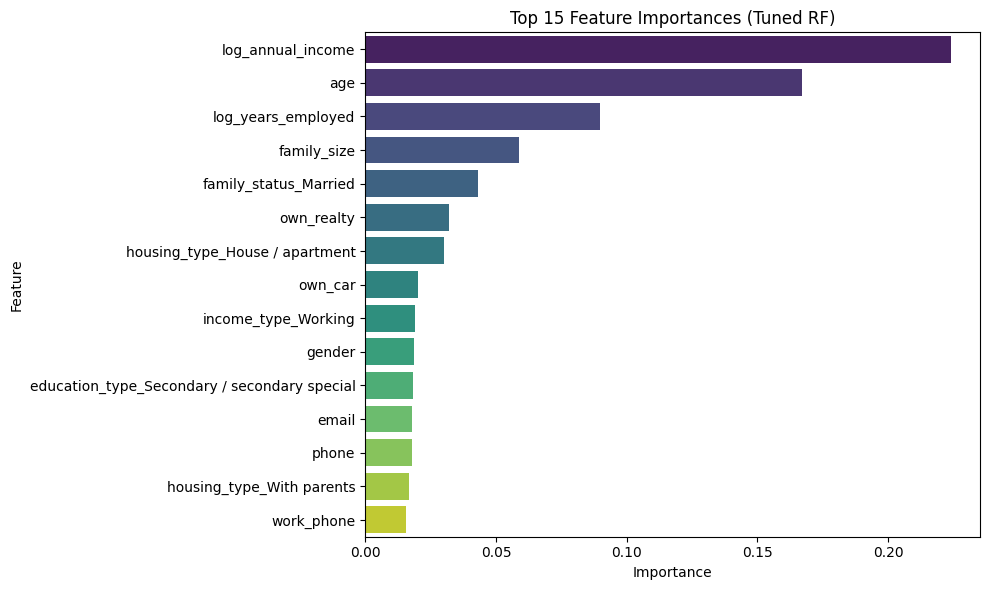

In [ ]:
### Chosen Hyperparameters based on Random Forest + Borderline SMOTE with best RECALL (scoring) rates for "Bad" class
# Further Threshold tuning based on current best hyperparameters, trying to ensure recall for "Bad" class is >= 0.50
# Random Forest + Borderline SMOTE + Hyperparameters tuned + Threshold Tuning


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Use best model parameters directly
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators = 100,
        max_depth = 10,
        min_samples_split = 2,
        min_samples_leaf = 2,
        max_features = 'sqrt',
        bootstrap = False,
        max_samples = None,
        class_weight = None,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# ✅ Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"\n✅ Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"\n⚠️ No threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

# Evaluation
print("\n🔍 Classification Report (Threshold Tuned):")
print(classification_report(y_test_binary, y_pred_custom, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_custom))

print(f"\n✅ Best Threshold: {best_threshold:.3f}")

prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")


# PRC Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ("Bad" class)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------
# Feature Importance Plot
# --------------------
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']

print("\n🔍 Top Features:")
print(feat_imp_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


✅ Selected Threshold (Recall ≥ 0.5): 0.464
Precision: 0.198, Recall: 0.505, F1: 0.285

🔍 Classification Report (Threshold Tuned):
              precision    recall  f1-score   support

        Good       0.94      0.80      0.87      6651
         Bad       0.20      0.51      0.28       641

    accuracy                           0.78      7292
   macro avg       0.57      0.65      0.58      7292
weighted avg       0.88      0.78      0.82      7292


🔍 Confusion Matrix:
[[5340 1311]
 [ 317  324]]

✅ Best Threshold: 0.464

📈 PRC AUC: 0.2217


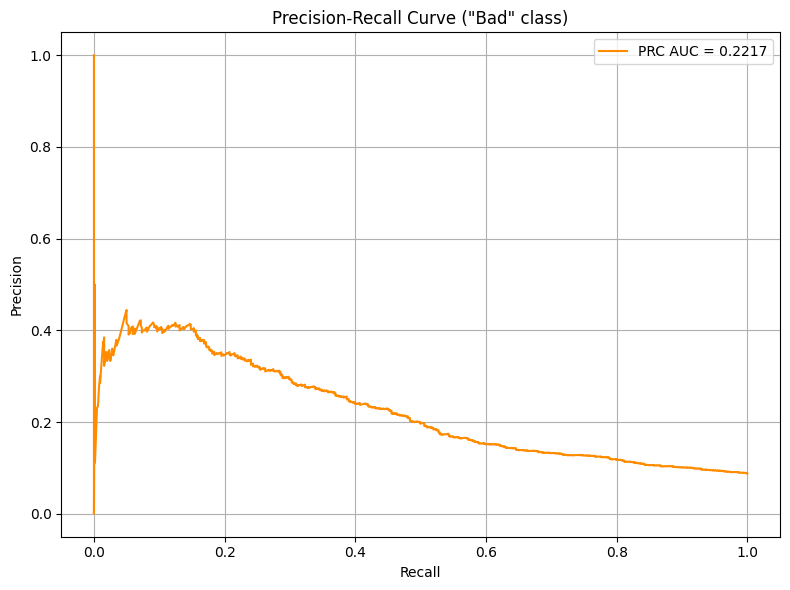


🔍 Top Features:
                                         Feature  Importance
0                              log_annual_income    0.201273
1                                            age    0.179811
2                             log_years_employed    0.118346
3                                    family_size    0.066530
4                                        own_car    0.026432
5                                     own_realty    0.024502
6                                          phone    0.024042
7                                         gender    0.022129
8                          family_status_Married    0.021304
9                            income_type_Working    0.021204
10                                    work_phone    0.019637
11  education_type_Secondary / secondary special    0.018472
12                housing_type_House / apartment    0.018040
13                             occupation_Others    0.017827
14               education_type_Higher education    0.017507


/var/folders/bm/l7y0dmw152vcmvqzjv7gpb6c0000gn/T/ipykernel_8223/316510386.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


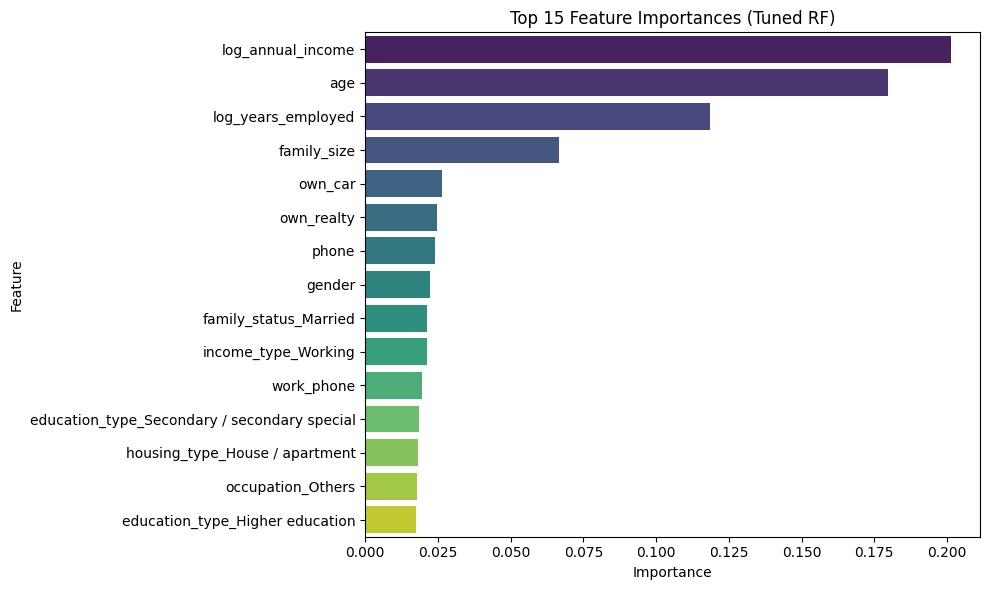

In [ ]:
### Chosen Hyperparameters based on Random Forest + NORMAL SMOTE with best RECALL (scoring) where "Bad" class is positive
# Further Threshold tuning based on current best hyperparameters, trying to ensure recall for "Bad" class is >= 0.50
# Random Forest + Borderline SMOTE + Hyperparameters tuned + Threshold Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_SMOTEd.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]


# Use best model parameters directly
pipeline = ImbPipeline([
    ('clf', RandomForestClassifier(
        n_estimators = 200,
        max_depth = 20,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = 'sqrt',
        bootstrap = False,
        max_samples = None,
        class_weight = None,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# ✅ Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"\n✅ Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"\n⚠️ No threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

# Evaluation
print("\n🔍 Classification Report (Threshold Tuned):")
print(classification_report(y_test_binary, y_pred_custom, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_custom))

print(f"\n✅ Best Threshold: {best_threshold:.3f}")

prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")


# PRC Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ("Bad" class)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------
# Feature Importance Plot
# --------------------
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']

print("\n🔍 Top Features:")
print(feat_imp_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


✅ Selected Threshold (Recall ≥ 0.5): 0.263
Precision: 0.244, Recall: 0.502, F1: 0.328

🔍 Classification Report (Threshold Tuned):
              precision    recall  f1-score   support

        Good       0.95      0.85      0.90      6651
         Bad       0.24      0.50      0.33       641

    accuracy                           0.82      7292
   macro avg       0.60      0.68      0.61      7292
weighted avg       0.88      0.82      0.85      7292


🔍 Confusion Matrix:
[[5653  998]
 [ 319  322]]

✅ Best Threshold: 0.263

📈 PRC AUC: 0.2765


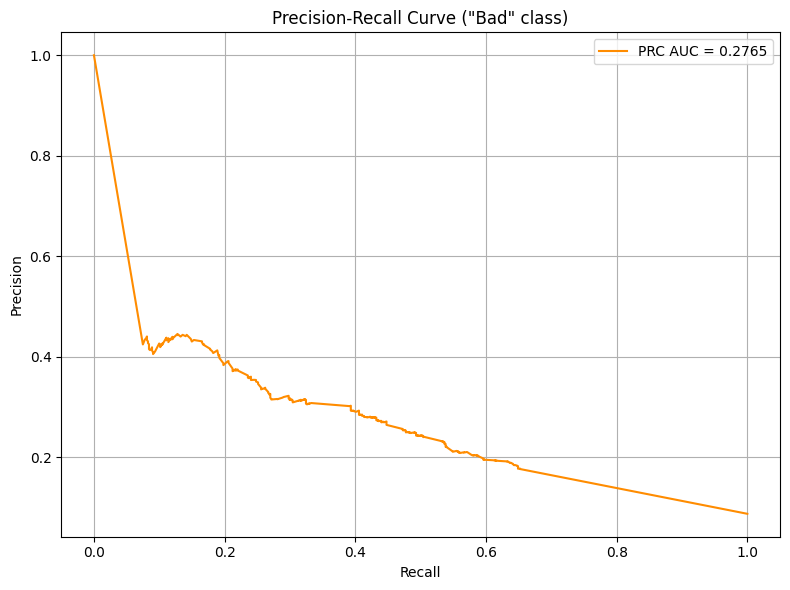


🔍 Top Features:
                                         Feature  Importance
0                              log_annual_income    0.223324
1                                            age    0.211565
2                             log_years_employed    0.135935
3                                    family_size    0.057585
4                                        own_car    0.026984
5                                          phone    0.022260
6                                         gender    0.021591
7                            income_type_Working    0.019957
8                                     own_realty    0.019855
9                                     work_phone    0.017631
10                             occupation_Others    0.016502
11  education_type_Secondary / secondary special    0.015274
12                         family_status_Married    0.015251
13                           occupation_Laborers    0.014916
14               education_type_Higher education    0.014536


/var/folders/bm/l7y0dmw152vcmvqzjv7gpb6c0000gn/T/ipykernel_8223/2926358540.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


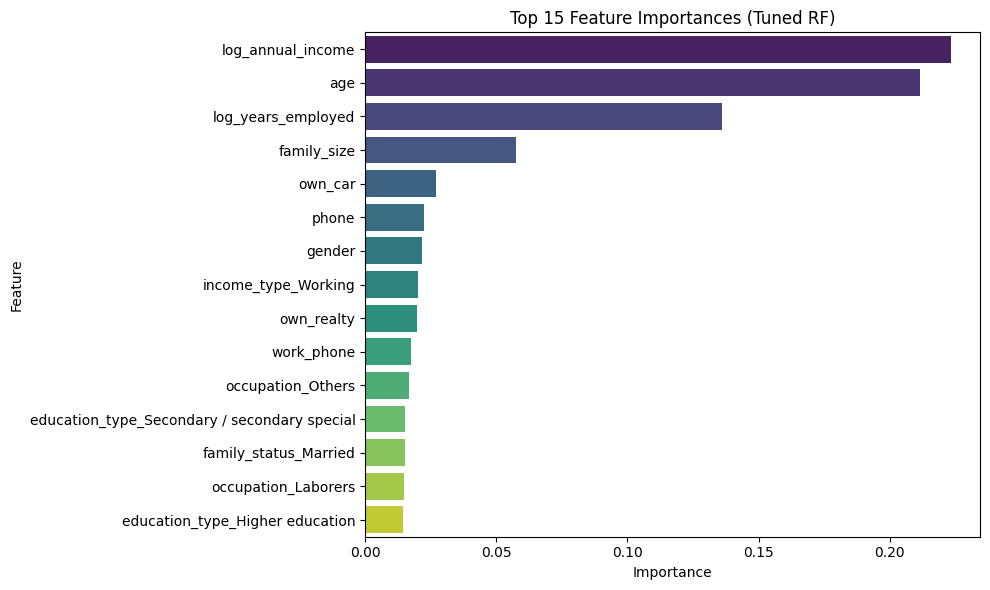

In [ ]:
### Chosen Hyperparameters based on Random Forest + NORMAL SMOTE with best F1 (scoring) where "Bad" class is positive
# Further Threshold tuning based on current best hyperparameters, trying to ensure recall for "Bad" class is >= 0.50
# Random Forest + Borderline SMOTE + Hyperparameters tuned + Threshold Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_SMOTEd.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]


# Use best model parameters directly
pipeline = ImbPipeline([
    ('clf', RandomForestClassifier(
        n_estimators = 200,
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = 'sqrt',
        bootstrap = False,
        max_samples = None,
        class_weight = None,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# ✅ Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"\n✅ Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"\n⚠️ No threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

# Evaluation
print("\n🔍 Classification Report (Threshold Tuned):")
print(classification_report(y_test_binary, y_pred_custom, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_custom))

print(f"\n✅ Best Threshold: {best_threshold:.3f}")

prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")


# PRC Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ("Bad" class)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------
# Feature Importance Plot
# --------------------
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']

print("\n🔍 Top Features:")
print(feat_imp_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


✅ Selected Threshold (Recall ≥ 0.5): 0.275
Precision: 0.240, Recall: 0.505, F1: 0.325

🔍 Classification Report (Threshold Tuned):
              precision    recall  f1-score   support

        Good       0.95      0.85      0.89      6651
         Bad       0.24      0.51      0.33       641

    accuracy                           0.82      7292
   macro avg       0.59      0.68      0.61      7292
weighted avg       0.88      0.82      0.84      7292


🔍 Confusion Matrix:
[[5625 1026]
 [ 317  324]]

✅ Best Threshold: 0.280

📈 PRC AUC: 0.2502


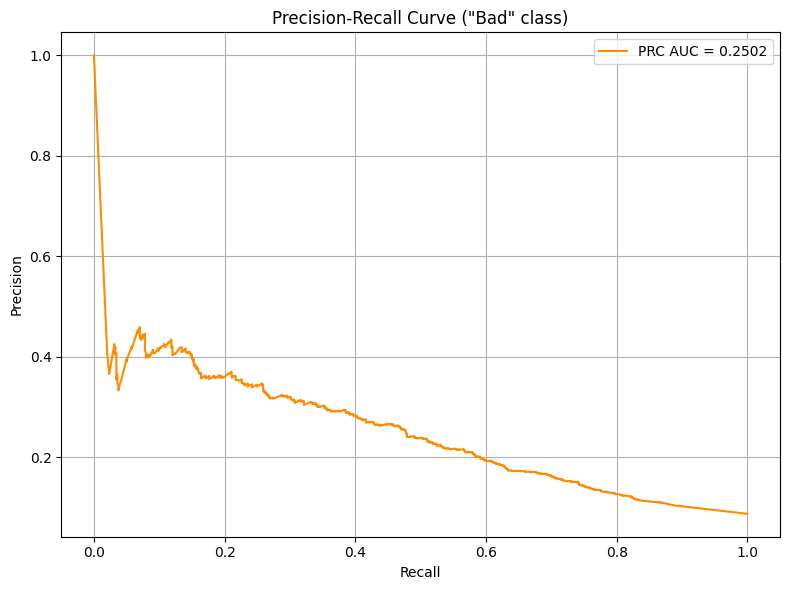


🔍 Top Features:
                                         Feature  Importance
0                              log_annual_income    0.218962
1                                            age    0.206955
2                             log_years_employed    0.135818
3                                    family_size    0.055518
4                                        own_car    0.027478
5                                          phone    0.025852
6                                         gender    0.022846
7                                     own_realty    0.020798
8                            income_type_Working    0.019902
9                                     work_phone    0.018942
10                             occupation_Others    0.016578
11  education_type_Secondary / secondary special    0.016289
12                         family_status_Married    0.015487
13               education_type_Higher education    0.015108
14                           occupation_Laborers    0.014388


/var/folders/bm/l7y0dmw152vcmvqzjv7gpb6c0000gn/T/ipykernel_68141/1344394811.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


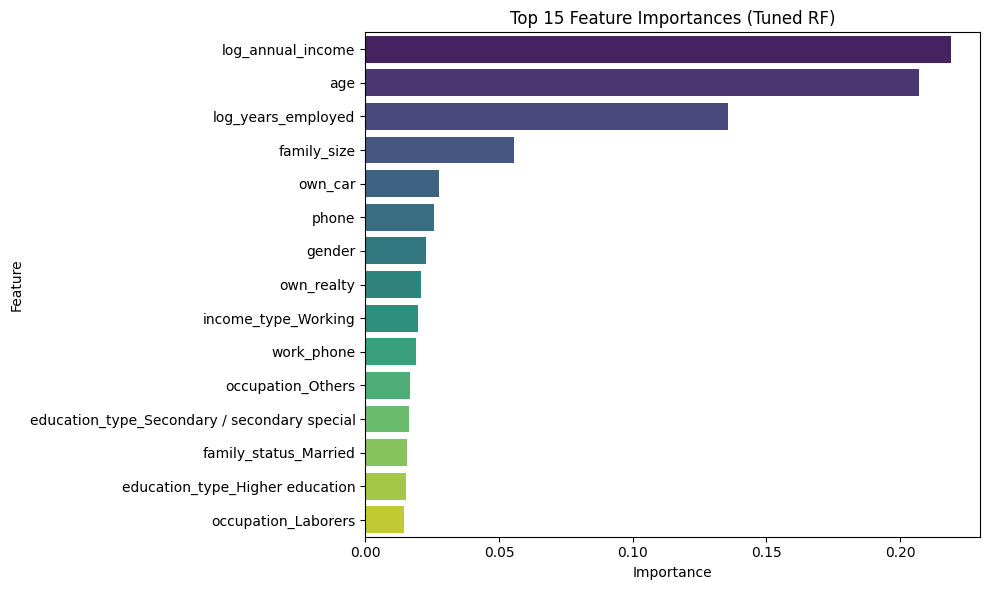

In [ ]:
### Chosen Hyperparameters based on Random Forest + Borderline SMOTE with best F1 (scoring) where "Bad" class is positive
# Further Threshold tuning based on current best hyperparameters, trying to ensure recall for "Bad" class is >= 0.50
# Random Forest + Borderline SMOTE + Hyperparameters tuned + Threshold Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_noSMOTE.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Drop known redundant features
redundant_features = ['annual_income', 'years_employed']
X_train_reduced = X_train.drop(columns=redundant_features)
X_test_reduced = X_test.drop(columns=redundant_features)

# Use best model parameters directly
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators = 200,
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = 'sqrt',
        bootstrap = True,
        max_samples = 0.8,
        class_weight = None,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train_reduced, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test_reduced)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# ✅ Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"\n✅ Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"\n⚠️ No threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

# Evaluation
print("\n🔍 Classification Report (Threshold Tuned):")
print(classification_report(y_test_binary, y_pred_custom, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_custom))

print(f"\n✅ Best Threshold: {best_threshold:.3f}")

prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")


# PRC Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ("Bad" class)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------
# Feature Importance Plot
# --------------------
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train_reduced.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']

print("\n🔍 Top Features:")
print(feat_imp_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


✅ Selected Threshold (Recall ≥ 0.5): 0.275
Precision: 0.240, Recall: 0.505, F1: 0.325

🔍 Classification Report (Threshold Tuned):
              precision    recall  f1-score   support

        Good       0.95      0.85      0.89      6651
         Bad       0.24      0.51      0.33       641

    accuracy                           0.82      7292
   macro avg       0.59      0.68      0.61      7292
weighted avg       0.88      0.82      0.84      7292


🔍 Confusion Matrix:
[[5625 1026]
 [ 317  324]]

✅ Best Threshold: 0.275

📈 PRC AUC: 0.2492


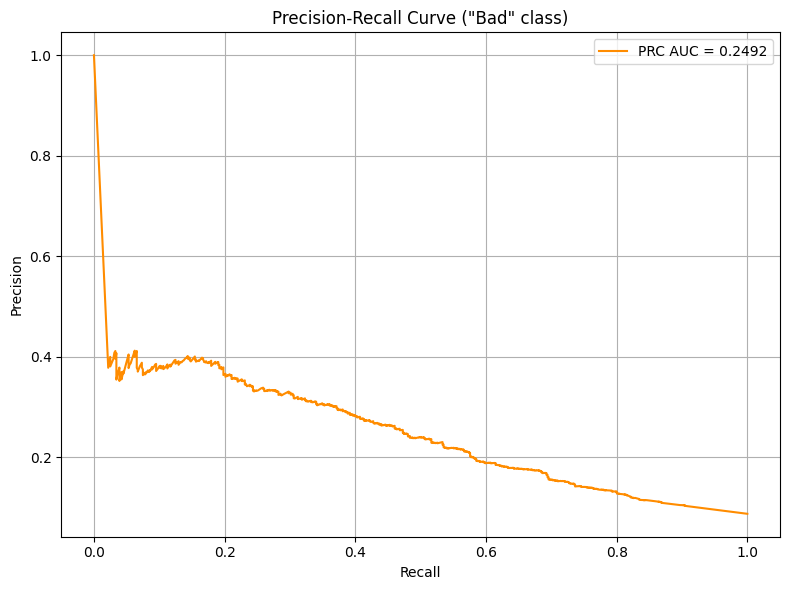


🔍 Top Features:
                                         Feature  Importance
0                              log_annual_income    0.219196
1                                            age    0.205463
2                             log_years_employed    0.136391
3                                    family_size    0.055888
4                                        own_car    0.028670
5                                          phone    0.023868
6                                         gender    0.022395
7                                     own_realty    0.021279
8                            income_type_Working    0.020557
9                                     work_phone    0.018295
10                             occupation_Others    0.016678
11  education_type_Secondary / secondary special    0.016418
12                         family_status_Married    0.015781
13               education_type_Higher education    0.015206
14                           occupation_Laborers    0.013661


C:\Users\sybel\AppData\Local\Temp\ipykernel_10628\92488825.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')


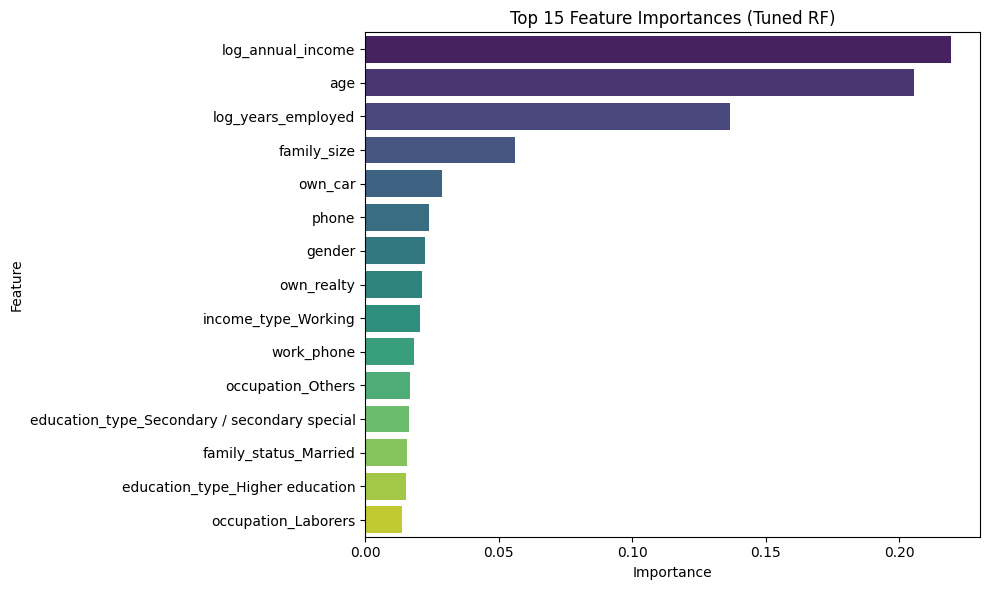

In [ ]:
### Chosen Hyperparameters based on RF + Borderline SMOTE with best F1 (scoring) where "Bad" class is positive
# Further Threshold tuning based on current best hyperparameters, trying to ensure recall for "Bad" class is >= 0.50
# Random Forest + Borderline SMOTE + Hyperparameters tuned + Threshold Tuning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, auc, f1_score, make_scorer
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

# Load datasets
train_set = pd.read_csv('../data/processed/train_set_noSMOTE.csv')
test_set = pd.read_csv('../data/processed/test_set.csv')

# Use consistent encoding: 'Bad' = 1, 'Good' = 0
y_train = (train_set['credit_status'] == 'Bad').astype(int)
y_test = (test_set['credit_status'] == 'Bad').astype(int)

# Define feature columns
feature_columns = [col for col in test_set.columns if col not in ["credit_status", "id"]]

X_train = train_set[feature_columns]
X_test = test_set[feature_columns]

# Drop known redundant features
redundant_features = ['annual_income', 'years_employed']
X_train_reduced = X_train.drop(columns=redundant_features)
X_test_reduced = X_test.drop(columns=redundant_features)

# Use best model parameters directly
pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators = 200,
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 1,
        max_features = 'sqrt',
        bootstrap = True,
        max_samples = 0.8,
        class_weight = None,
        random_state = 42
    ))
])

# Fit the best model
pipeline.fit(X_train_reduced, y_train)

# Compute predicted probabilities for class 1 = Bad
y_proba = pipeline.predict_proba(X_test_reduced)[:, 1]

# Use actual test labels (already 1 = Bad, 0 = Good)
y_test_binary = y_test

# Predict probabilities for class 1 ("Bad")
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_proba, pos_label=1)

# ✅ Set recall cutoff for Bad class (class 1)
recall_cutoff = 0.5

# Compute F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Zip into list of (threshold, precision, recall, f1)
threshold_results = list(zip(thresholds, precision[:-1], recall[:-1], f1_scores[:-1]))

# Filter for thresholds where recall ≥ cutoff
qualified = [res for res in threshold_results if res[2] >= recall_cutoff]

if qualified:
    # Pick threshold with highest F1 score
    best_threshold, best_precision, best_recall, best_f1 = max(qualified, key=lambda x: x[3])
    print(f"\n✅ Selected Threshold (Recall ≥ {recall_cutoff}): {best_threshold:.3f}")
    print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
else:
    best_threshold = 0.5
    print(f"\n⚠️ No threshold achieves recall ≥ {recall_cutoff}. Using default 0.5.")
    
# Apply chosen threshold
y_pred_custom = (y_proba >= best_threshold).astype(int)

############################################################################################## Add predictions to test set##################################################################################
test_set['predicted_credit_status'] = y_pred_custom
test_set['credit_status'] = y_test_binary

############################################################################################# Save the test set with predictions######################################################################################
test_set.to_csv('test_set_with_predictions.csv', index=False)

# Evaluation
print("\n🔍 Classification Report (Threshold Tuned):")
print(classification_report(y_test_binary, y_pred_custom, target_names=['Good', 'Bad']))

print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test_binary, y_pred_custom))

print(f"\n✅ Best Threshold: {best_threshold:.3f}")

prc_auc = auc(recall, precision)
print(f"\n📈 PRC AUC: {prc_auc:.4f}")


# PRC Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PRC AUC = {prc_auc:.4f}', color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve ("Bad" class)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------
# Feature Importance Plot
# --------------------
clf = pipeline.named_steps['clf']
feat_importances = pd.Series(clf.feature_importances_, index=X_train_reduced.columns)
feat_imp_df = feat_importances.sort_values(ascending=False).reset_index()
feat_imp_df.columns = ['Feature', 'Importance']

print("\n🔍 Top Features:")
print(feat_imp_df.head(15))

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Tuned RF)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()